In [1]:
from google.colab import drive
drive.mount('/Research')

Drive already mounted at /Research; to attempt to forcibly remount, call drive.mount("/Research", force_remount=True).


In [2]:
pip install python_speech_features

In [3]:
import pandas as pd       
import os 
import math 
import numpy as np
import matplotlib.pyplot as plt  
import IPython.display as ipd
import librosa as lr
import librosa.display
from glob import glob
from tqdm import tqdm
import scipy.io
from os.path import dirname, join as pjoin
from scipy.io import wavfile
from python_speech_features import mfcc, logfbank
from sklearn.model_selection import train_test_split
from keras.layers import Dropout, TimeDistributed
from keras import regularizers
from keras.callbacks import EarlyStopping
from keras.models import Model
from keras.preprocessing import image
from keras.models import Sequential
from keras.utils import plot_model
from keras.models import load_model
import tensorflow as tf
from keras.utils import to_categorical
from sklearn.utils.class_weight import compute_class_weight
import keras
import pickle
from keras.callbacks import ModelCheckpoint
from keras.layers import LSTM, Dense, Flatten
from keras.callbacks import ReduceLROnPlateau
from sklearn.metrics import roc_curve, roc_auc_score, auc
from sklearn.metrics import  average_precision_score, precision_recall_curve
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
from sklearn.metrics import mean_absolute_error
import seaborn as sns
from sklearn.metrics import mean_squared_error

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [4]:
new_df = pd.read_csv('/Research/My Drive/Research/new_df.csv')
new_df.head()

,age,age_onset,birthplace,filename,native_language,sex,speakerid,country,file_missing?,vid_len,age_group,clean_len
0,27.0,9.0,"virginia, south africa",afrikaans1,afrikaans,female,1,south africa,False,20.772268,Millennials,20.772313
1,40.0,5.0,"pretoria, south africa",afrikaans2,afrikaans,male,2,south africa,False,21.961497,Millennials,21.496500
2,43.0,4.0,"pretoria, transvaal, south africa",afrikaans3,afrikaans,male,418,south africa,False,26.880000,Baby Boomers,26.880000
3,26.0,8.0,"pretoria, south africa",afrikaans4,afrikaans,male,1159,south africa,False,23.471179,Millennials,23.020312
4,19.0,6.0,"cape town, south africa",afrikaans5,afrikaans,male,1432,south africa,False,20.252404,Gen Z,20.252437


In [5]:
n_samples = 2*int(new_df['clean_len'].sum())
classes = list(np.unique(new_df.age_group))
class_dist = new_df.groupby(['age_group'])['clean_len'].mean()
prob_dist = class_dist/class_dist.sum()
choices = np.random.choice(class_dist.index, p=prob_dist)

In [6]:
class_dist

age_group
Alpha           22.473844
Baby Boomers    30.327223
Gen Z           24.893638
Millennials     27.402976
Name: clean_len, dtype: float64

In [7]:
prob_dist

age_group
Alpha           0.213838
Baby Boomers    0.288562
Gen Z           0.236862
Millennials     0.260738
Name: clean_len, dtype: float64

In [8]:
choices

'Baby Boomers'

In [9]:
new_df.set_index('filename', inplace=True)

In [10]:
def check_data():
  if os.path.isfile(pickles_path):
    with open(pickles_path, 'rb') as handle:
      tmp = pickle.load(handle)
      return tmp
  else:
    return None

In [11]:
def build_random_feat():
  X = []
  y = []
  _min, _max = float('inf'), -float('inf')
  for _ in tqdm(range(n_samples)):
    rand_class = np.random.choice(class_dist.index, p=prob_dist)
    file = np.random.choice(new_df[new_df.age_group==rand_class].index)
    path = os.path.join("/Research/My Drive/Research/recordings/Clean",file+".wav")
    rate, wav = wavfile.read(path)
    age_group = new_df.at[file, 'age_group']
    rand_index = np.random.randint(0, wav.shape[0]-int(rate))
    sample = wav[rand_index:rand_index+int(rate)]
    X_sample = mfcc(sample, rate, numcep=13, nfilt=26, nfft=512)
    _min = min(np.amin(X_sample), _min)
    _max = max(np.amax(X_sample), _max)
    X.append(X_sample)
    y.append(classes.index(age_group))
  X, y = np.array(X), np.array(y)
  X = (X- _min) / (_max - _min)
  X = X.reshape(X.shape[0], X.shape[1], X.shape[2])
  y = to_categorical(y, num_classes=4)
  return X, y

In [12]:
model_path = os.path.join('Models')
pickles_path = os.path.join('pickles', '.p')

In [13]:
X, y = build_random_feat()

100%|██████████| 115916/115916 [16:58<00:00, 113.76it/s]


In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=2, test_size=0.2)

In [15]:
input_shape = (X.shape[1], X.shape[2])

In [16]:
y_trains = np.argmax(y_train, axis=1)

In [17]:
optimizer = keras.optimizers.Adam(learning_rate=0.0001)

In [18]:
model = Sequential()
model.add(LSTM(256, input_shape = input_shape, return_sequences=True))
model.add(LSTM(128, return_sequences=True))
model.add(LSTM(128, return_sequences=True))
model.add(Dropout(0.5))
model.add(TimeDistributed(Dense(64, activation='relu')))
model.add(TimeDistributed(Dense(32, activation='relu')))
model.add(TimeDistributed(Dense(16, activation='relu')))
model.add(TimeDistributed(Dense(8, activation='relu')))
model.add(Flatten())
model.add(Dense(4, activation='softmax'))

In [19]:
LEARNING_RATE = 0.0001
PATIENCE = 5
RLROP = 2
DECAY_DROP = 0.2

In [20]:
es = EarlyStopping(monitor='val_loss', mode='min', patience=PATIENCE, restore_best_weights=True, verbose=1)
rlrop = ReduceLROnPlateau(monitor='val_loss', mode='min', patience=RLROP, factor=DECAY_DROP, min_lr=1e-6, verbose=1)
 
callback_list = [es, rlrop]
model.compile(optimizer=optimizer, loss="binary_crossentropy",  metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 99, 256)           276480    
_________________________________________________________________
lstm_1 (LSTM)                (None, 99, 128)           197120    
_________________________________________________________________
lstm_2 (LSTM)                (None, 99, 128)           131584    
_________________________________________________________________
dropout (Dropout)            (None, 99, 128)           0         
_________________________________________________________________
time_distributed (TimeDistri (None, 99, 64)            8256      
_________________________________________________________________
time_distributed_1 (TimeDist (None, 99, 32)            2080      
_________________________________________________________________
time_distributed_2 (TimeDist (None, 99, 16)            5

In [21]:
result = model.fit(X_train,y_train,epochs=50,batch_size=32,validation_data=(X_test,y_test), callbacks=callback_list)

Epoch 1/50
2898/2898 [==============================] - 56s 19ms/step - loss: 0.4771 - accuracy: 0.4100 - val_loss: 0.4707 - val_accuracy: 0.4423
Epoch 2/50
2898/2898 [==============================] - 55s 19ms/step - loss: 0.4012 - accuracy: 0.4840 - val_loss: 0.3843 - val_accuracy: 0.5069
Epoch 3/50
2898/2898 [==============================] - 56s 19ms/step - loss: 0.3840 - accuracy: 0.5104 - val_loss: 0.3822 - val_accuracy: 0.5214
Epoch 4/50
2898/2898 [==============================] - 56s 19ms/step - loss: 0.3753 - accuracy: 0.5303 - val_loss: 0.3721 - val_accuracy: 0.5442
Epoch 5/50
2898/2898 [==============================] - 56s 19ms/step - loss: 0.3690 - accuracy: 0.5453 - val_loss: 0.3661 - val_accuracy: 0.5526
Epoch 6/50
2898/2898 [==============================] - 56s 19ms/step - loss: 0.3638 - accuracy: 0.5569 - val_loss: 0.3583 - val_accuracy: 0.5627
Epoch 7/50
2898/2898 [==============================] - 55s 19ms/step - loss: 0.3611 - accuracy: 0.5648 - val_loss: 0.3560 -

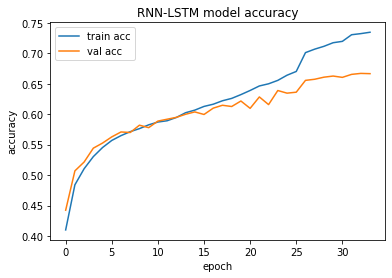

<Figure size 432x288 with 0 Axes>

In [22]:
plt.plot(result.history['accuracy'], label='train acc')
plt.plot(result.history['val_accuracy'], label='val acc')
plt.title('RNN-LSTM model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

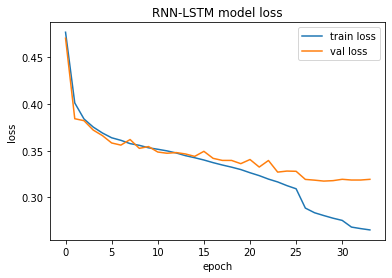

<Figure size 432x288 with 0 Axes>

In [23]:
plt.plot(result.history['loss'], label='train loss')
plt.plot(result.history['val_loss'], label='val loss')
plt.legend()
plt.title('RNN-LSTM model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()
plt.savefig('LossVal_loss')

In [24]:
yhat = np.argmax(model.predict(X_test), axis=-1)
yhat_classes = np.argmax(model.predict_classes(X_test), axis=-1)

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


In [25]:
y_test = np.argmax(y_test, axis=1)

In [32]:
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_test, yhat)
print('Accuracy of RNN: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_test, yhat, pos_label='positive', average='micro')
print('Precision of RNN: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_test, yhat, pos_label='positive', average='micro')
print('Recall of RNN: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_test, yhat, pos_label='positive', average='micro')
print('F1 score of RNN: %f' % f1)

Accuracy of RNN: 0.660714
Precision of RNN: 0.660714
Recall of RNN: 0.660714
F1 score of RNN: 0.660714


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1321: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'micro'). You may use labels=[pos_label] to specify a single positive class.
  % (pos_label, average), UserWarning)


In [27]:
mean_absolute_error(y_test,yhat)

0.4644151138716356

Text(0.5, 15.0, 'Predicted label')

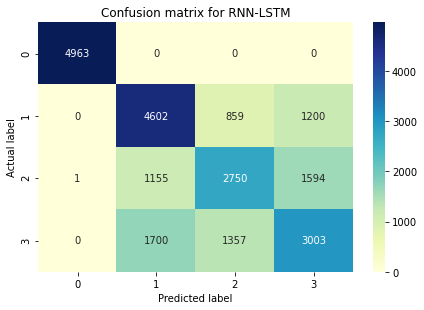

In [31]:
cm = confusion_matrix(y_test, yhat)
#print(cm)
# create heatmap
sns.heatmap(pd.DataFrame(cm), annot=True, cmap="YlGnBu" ,fmt='g')
 
plt.tight_layout()
plt.title('Confusion matrix for RNN-LSTM', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [29]:
checkpoint_RNN = ModelCheckpoint(model_path, monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=False, period=1)

In [30]:
model.save(model_path)

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: Models/assets
